**Import Requirements**

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import CSVLogger, ReduceLROnPlateau, EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [3]:
SEGMENT_CLASSES = {
    0 : 'NOT tumor',
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE
    2 : 'EDEMA',
    3 : 'ENHANCING' 
}

# there are 155 slices per volume
VOLUME_SLICES = 128
VOLUME_START_AT = 13 # first slice of volume that we will include

In [4]:
TRAIN_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
VALIDATION_DATASET_PATH = '../input/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

**Exploratory Data Analysis**

In [5]:
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

In [6]:
def visualize_brats_patient_slice(patient_id, slice_idx):
    base_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    subject_path = os.path.join(base_path, patient_id)

    # Define paths to modalities and segmentation
    modality_paths = {
        'T1': os.path.join(subject_path, f"{patient_id}_t1.nii"),
        'T1ce': os.path.join(subject_path, f"{patient_id}_t1ce.nii"),
        'T2': os.path.join(subject_path, f"{patient_id}_t2.nii"),
        'FLAIR': os.path.join(subject_path, f"{patient_id}_flair.nii"),
        'Seg': os.path.join(subject_path, f"{patient_id}_seg.nii")
    }

    # Load the volumes
    modalities = {key: nib.load(path).get_fdata() for key, path in modality_paths.items()}
    slices = {key: vol[:, :, slice_idx] for key, vol in modalities.items()}

    # Create colored segmentation mask
    def get_colored_mask(seg_slice):
        colored_mask = np.zeros((*seg_slice.shape, 3), dtype=np.float32)
        colored_mask[seg_slice == 1] = [0, 1, 0]  # green for NCR/NET
        colored_mask[seg_slice == 2] = [0, 0, 1]  # blue for ED
        colored_mask[seg_slice == 4] = [1, 0, 0]  # red for ET
        return colored_mask

    
    seg_colored = get_colored_mask(slices['Seg'])
    fig, axes = plt.subplots(1, 5, figsize=(20, 5))
    modality_order = ['T1', 'T1ce', 'T2', 'FLAIR']

    for i, modality in enumerate(modality_order):
        axes[i].imshow(slices[modality].T, cmap='gray', origin='lower')
        axes[i].set_title(modality, fontsize=14)
        axes[i].axis('off')

    # Segmentation mask only
    axes[4].imshow(seg_colored.transpose((1, 0, 2)), origin='lower')
    axes[4].set_title("Segmentation Mask", fontsize=14)
    axes[4].axis('off')

    plt.suptitle(f"BraTS2020: {patient_id} | Axial Slice {slice_idx}", fontsize=16)
    plt.tight_layout()
    plt.show()

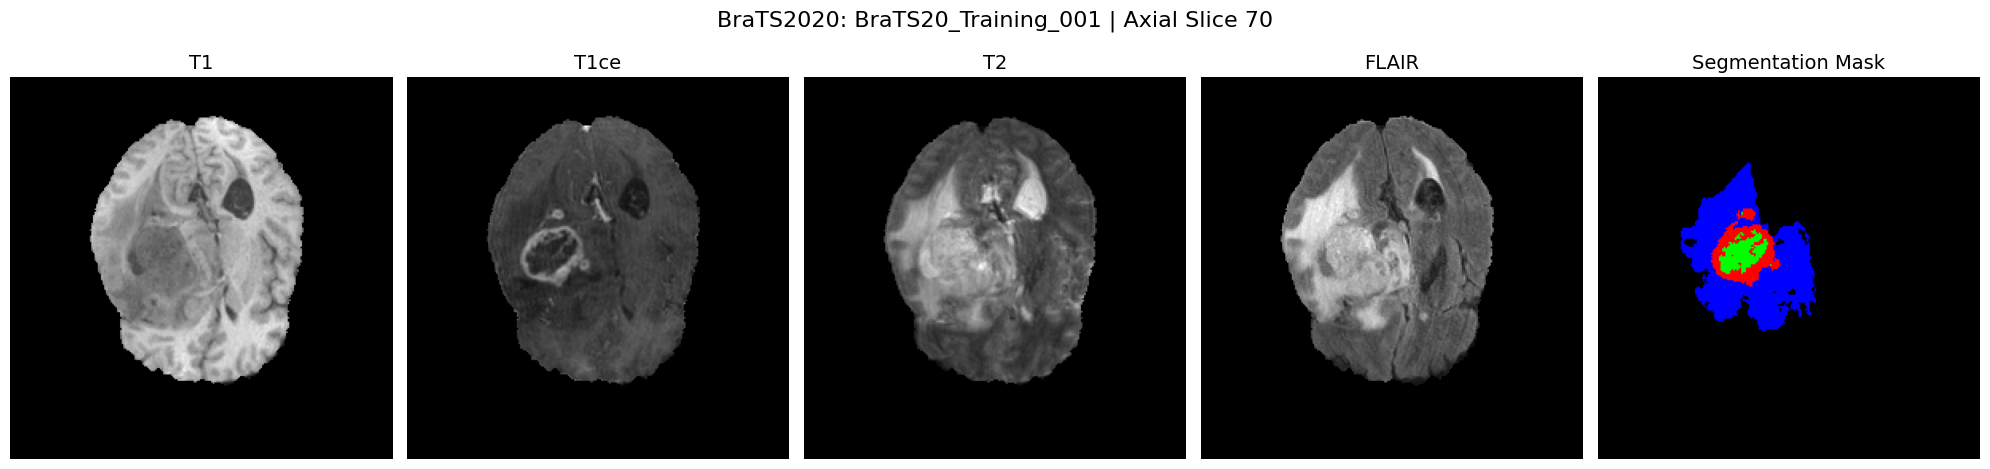

In [7]:
visualize_brats_patient_slice('BraTS20_Training_001', 70)

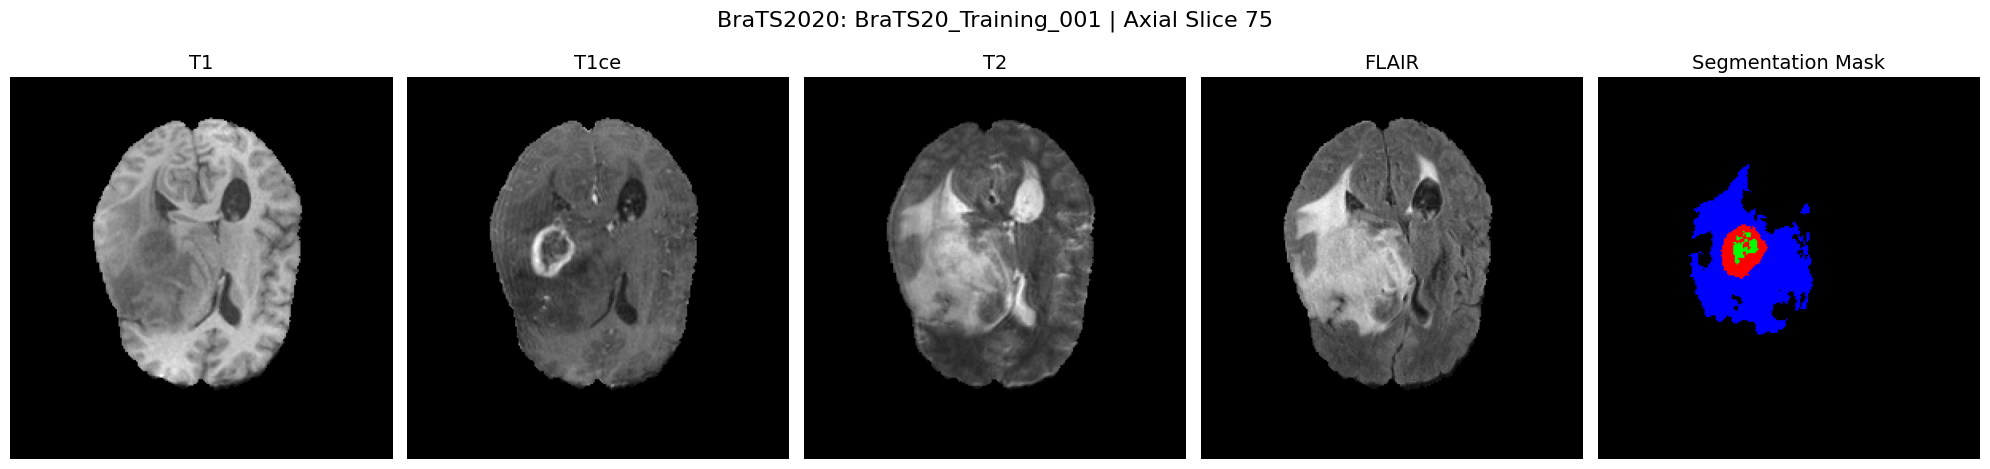

In [8]:
visualize_brats_patient_slice('BraTS20_Training_001', 75)

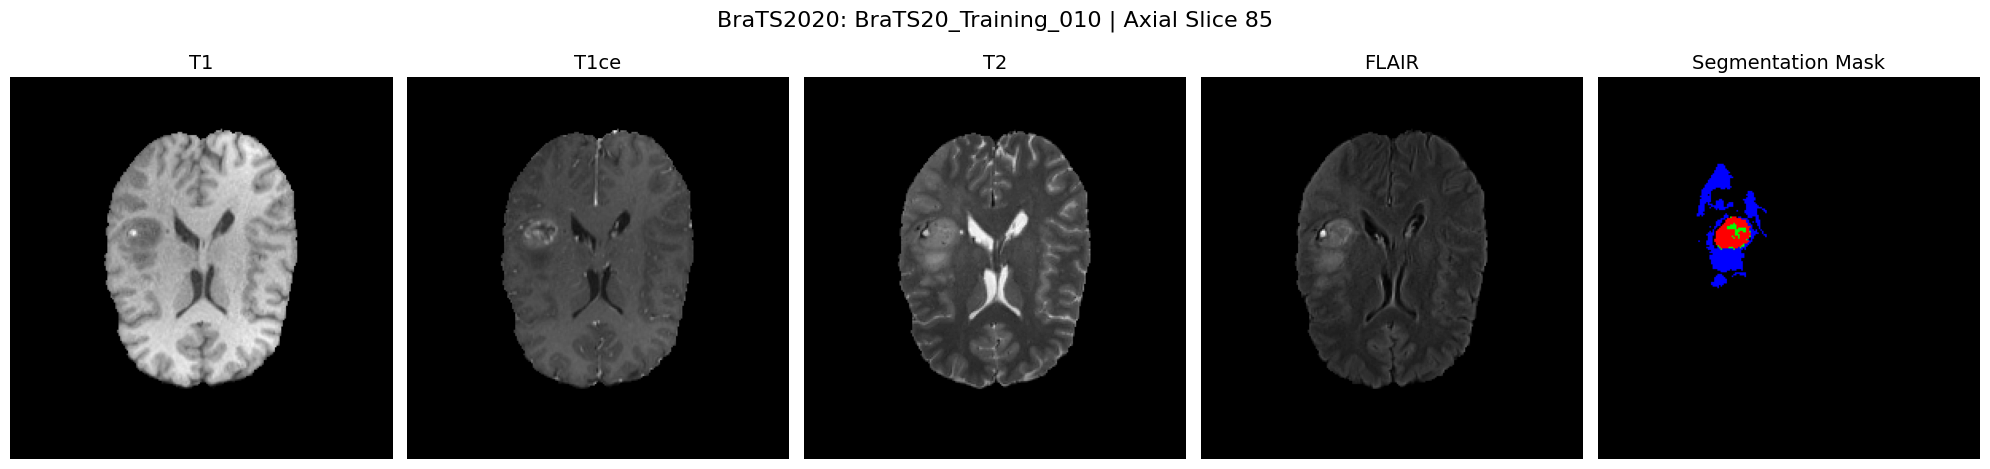

In [9]:
visualize_brats_patient_slice('BraTS20_Training_010', 85)

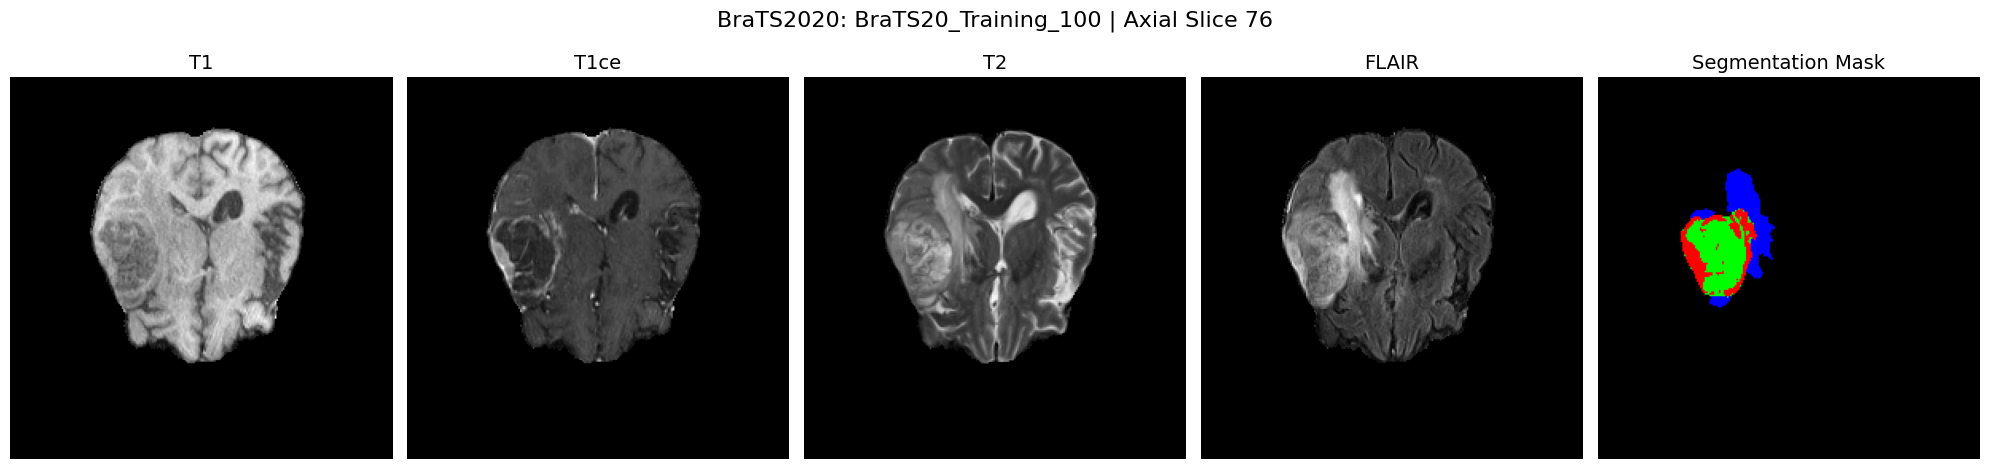

In [10]:
visualize_brats_patient_slice('BraTS20_Training_100', 76)

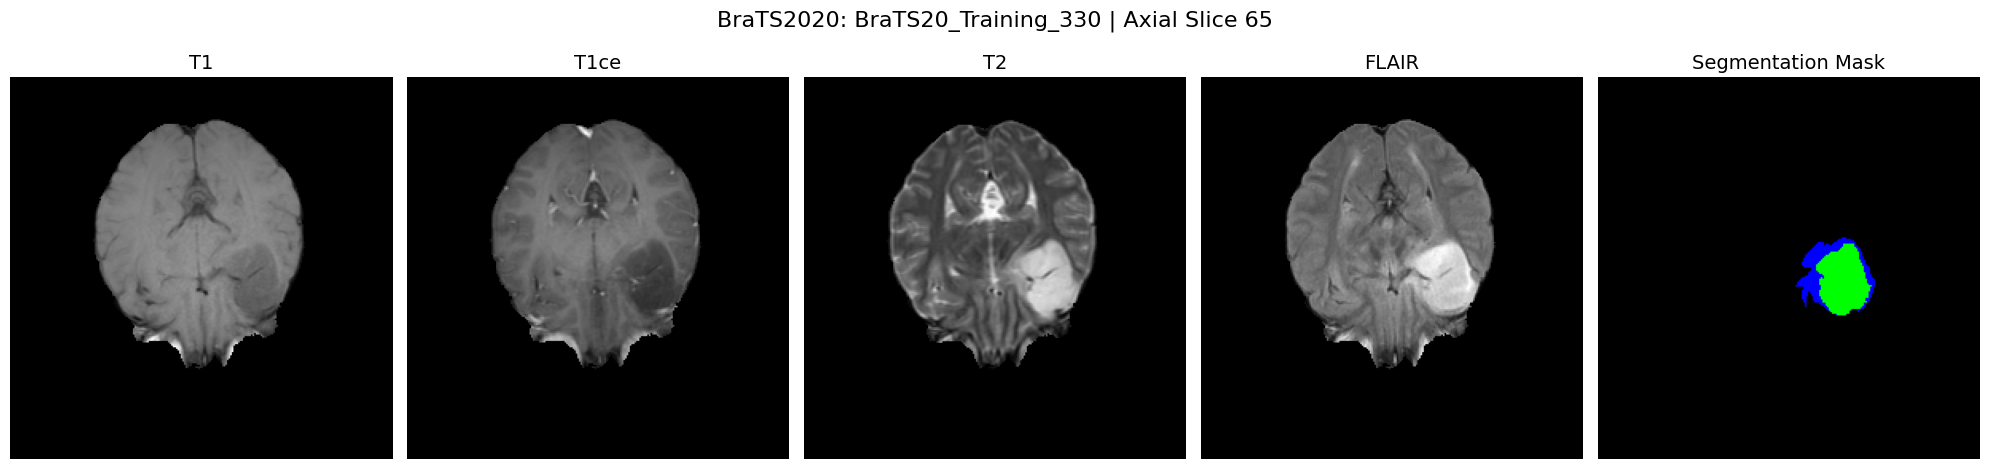

In [11]:
visualize_brats_patient_slice('BraTS20_Training_330', 65)

In [12]:
def visualize_patient_views_single_slice(patient_id, modality, slice_idx):
    base_path = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
    subject_path = os.path.join(base_path, patient_id)
    modality_path = os.path.join(subject_path, f"{patient_id}_{modality.lower()}.nii")
    seg_path = os.path.join(subject_path, f"{patient_id}_seg.nii")

    # Load volumes
    modality_vol = nib.load(modality_path).get_fdata()
    seg_vol = nib.load(seg_path).get_fdata()

    # Extract slices in all 3 views using the same index
    slices = {
        'axial': modality_vol[:, :, slice_idx],
        'coronal': modality_vol[:, slice_idx, :],
        'sagittal': modality_vol[slice_idx, :, :]
    }

    seg_slices = {
        'axial': seg_vol[:, :, slice_idx],
        'coronal': seg_vol[:, slice_idx, :],
        'sagittal': seg_vol[slice_idx, :, :]
    }

    # Create color segmentation mask
    def get_colored_mask(seg_slice):
        mask = np.zeros((*seg_slice.shape, 3), dtype=np.float32)
        mask[seg_slice == 1] = [0, 1, 0]  # Green - NCR/NET
        mask[seg_slice == 2] = [0, 0, 1]  # blue - Edema
        mask[seg_slice == 4] = [1, 0, 0]  # red - Enhancing Tumor
        return mask

    # Plotting
    views = ['axial', 'coronal', 'sagittal']
    fig, axes = plt.subplots(2, 3, figsize=(18, 8))

    for i, view in enumerate(views):
        # Top row: modality
        axes[0, i].imshow(slices[view].T, cmap='gray', origin='lower')
        axes[0, i].set_title(f'{modality} - {view.title()} View', fontsize=13)
        axes[0, i].axis('off')

        # Bottom row: segmentation
        mask_rgb = get_colored_mask(seg_slices[view])
        axes[1, i].imshow(mask_rgb.transpose((1, 0, 2)), origin='lower')
        axes[1, i].set_title(f'Segmentation - {view.title()} View', fontsize=13)
        axes[1, i].axis('off')

    plt.suptitle(f'{patient_id} | Modality: {modality} | Slice: {slice_idx}', fontsize=16)
    plt.tight_layout()
    plt.show()


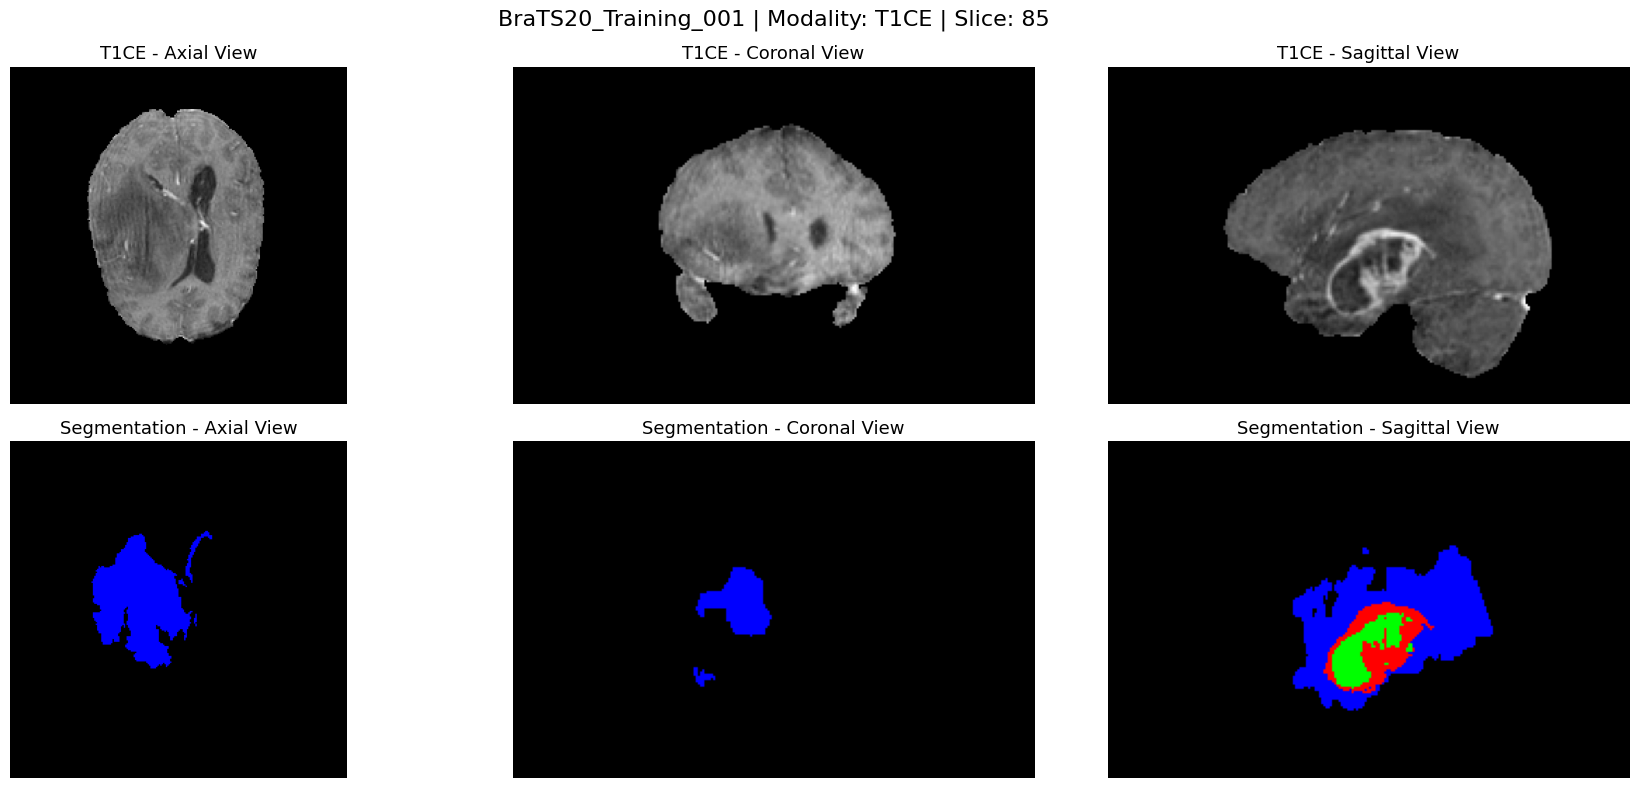

In [13]:
visualize_patient_views_single_slice('BraTS20_Training_001', 'T1CE', 85)

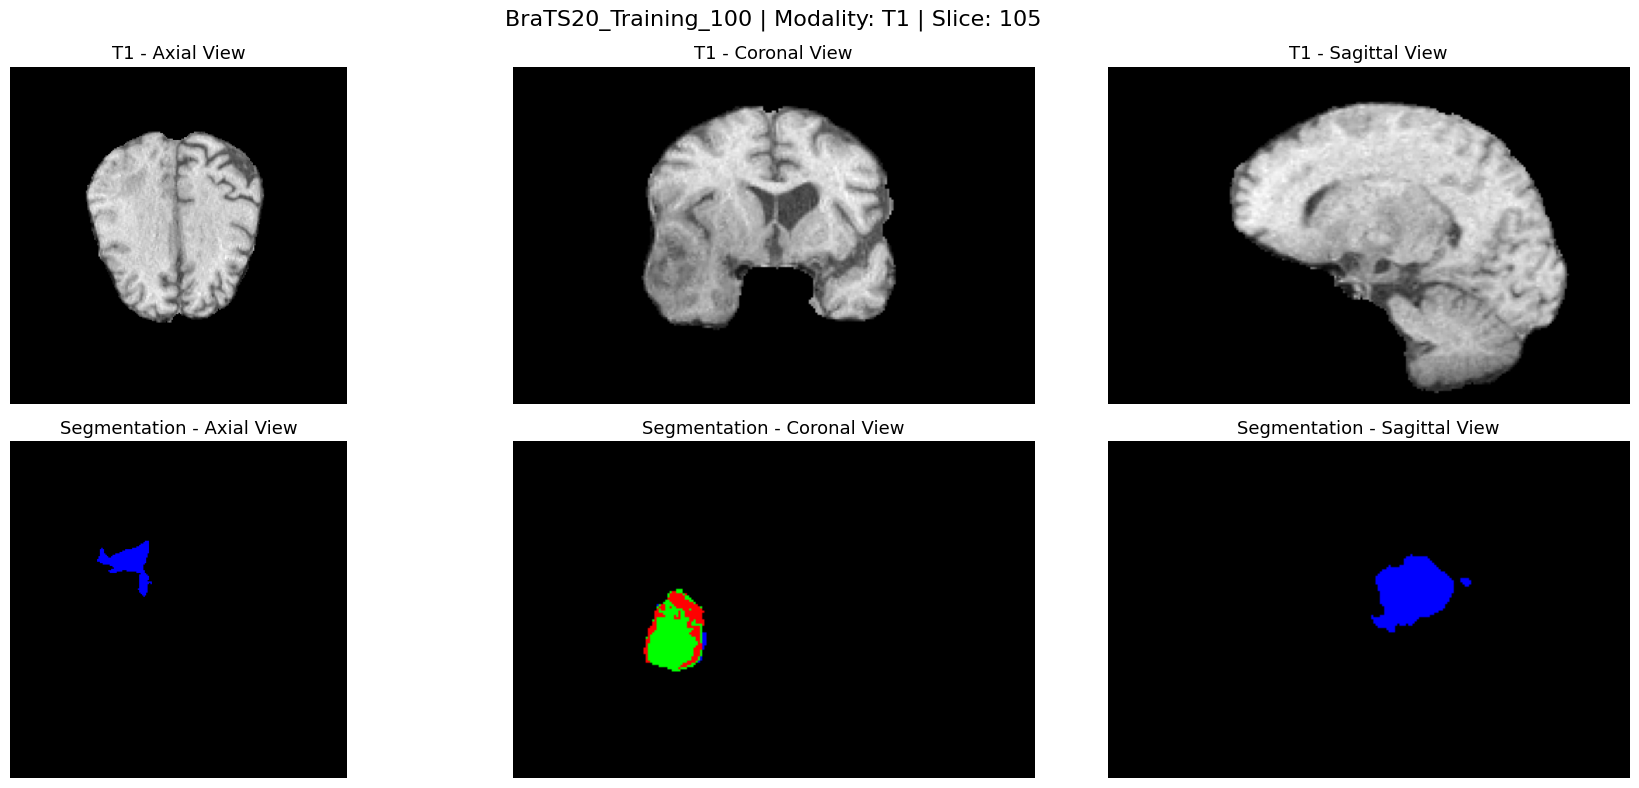

In [14]:
visualize_patient_views_single_slice('BraTS20_Training_100', 'T1', 105)

**View preprocessed images**

In [15]:
def normalize_volume(volume):
    mean = np.mean(volume)
    std = np.std(volume)
    return (volume - mean) / (std + 1e-8)

def load_and_preprocess(patient_id, dataset_path):
    case_path = os.path.join(dataset_path, patient_id)

    flair = nib.load(os.path.join(case_path, f'{patient_id}_flair.nii')).get_fdata()
    t2 = nib.load(os.path.join(case_path, f'{patient_id}_t2.nii')).get_fdata()
    ce = nib.load(os.path.join(case_path, f'{patient_id}_t1ce.nii')).get_fdata()
    t1 = nib.load(os.path.join(case_path, f'{patient_id}_t1.nii')).get_fdata()
    seg = nib.load(os.path.join(case_path, f'{patient_id}_seg.nii')).get_fdata()

    # Normalize
    flair = normalize_volume(flair)
    t2 = normalize_volume(t2)
    ce = normalize_volume(ce)
    t1 = normalize_volume(t1)

    # Crop
    flair = flair[56:184, 56:184, 13:141]
    t2 = t2[56:184, 56:184, 13:141]
    ce = ce[56:184, 56:184, 13:141]
    t1 = t1[56:184, 56:184, 13:141]
    seg = seg[56:184, 56:184, 13:141]
    seg = np.where(seg == 4, 3, seg)

    return flair, t1, ce, t2, seg
def convert_seg_to_rgb(seg_slice):
    rgb = np.zeros(seg_slice.shape + (3,), dtype=np.uint8)

    
    rgb[seg_slice == 1] = [0, 255, 0]
    rgb[seg_slice == 2] = [0, 0, 255]   
    rgb[seg_slice == 3] = [255, 0, 0]    

    return rgb

def visualize_modalities(flair, t1, ce, t2, seg, slice_index=64):
    modalities = [flair, t1, ce, t2]
    titles = ['Flair', 'T1', 'T1ce', 'T2', 'Segmentation']
    
    plt.figure(figsize=(20, 5))
    for i, modality in enumerate(modalities):
        plt.subplot(1, 5, i+1)
        plt.imshow(np.rot90(modality[:, :, slice_index]), cmap='gray')
        plt.title(titles[i])
        plt.axis('off')

    # Convert segmentation to RGB
    rgb_seg = convert_seg_to_rgb(np.rot90(seg[:, :, slice_index]))
    plt.subplot(1, 5, 5)
    plt.imshow(rgb_seg)
    plt.title(titles[4])
    plt.axis('off')

    plt.tight_layout()
    plt.show()

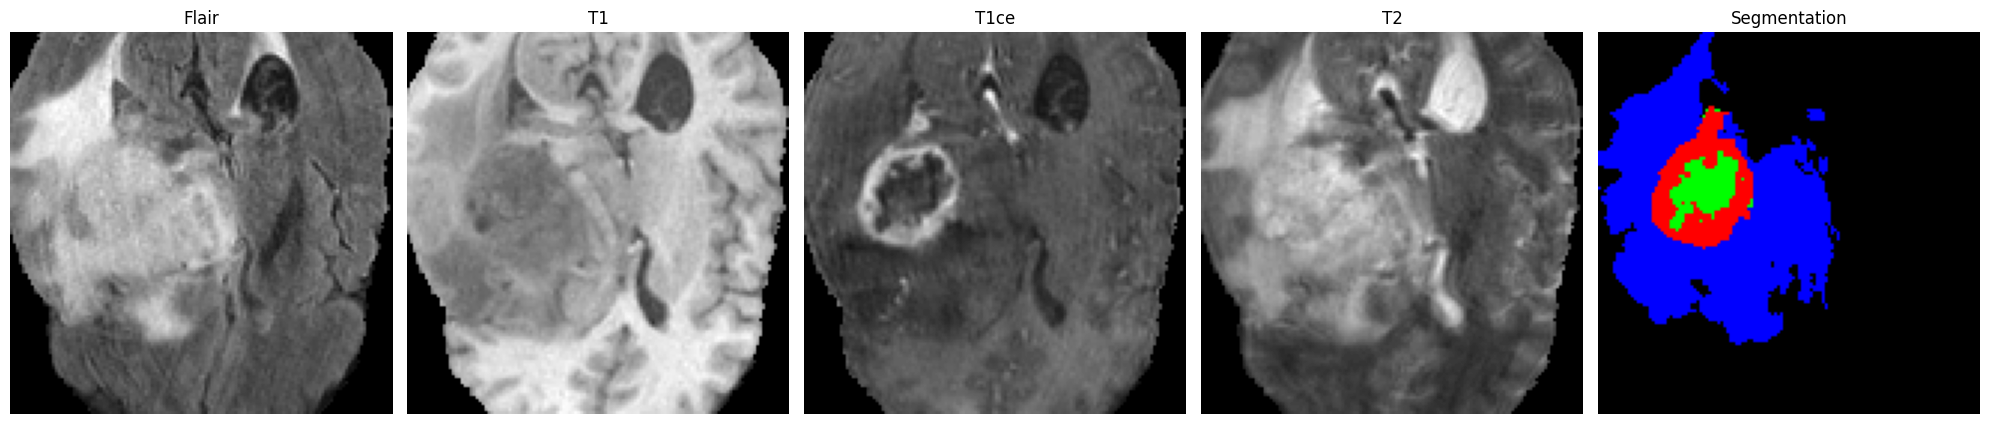

In [16]:
PATIENT_ID = 'BraTS20_Training_001'
DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
flair, t1, ce, t2, seg = load_and_preprocess(PATIENT_ID, DATASET_PATH)
visualize_modalities(flair, t1, ce, t2, seg,59)

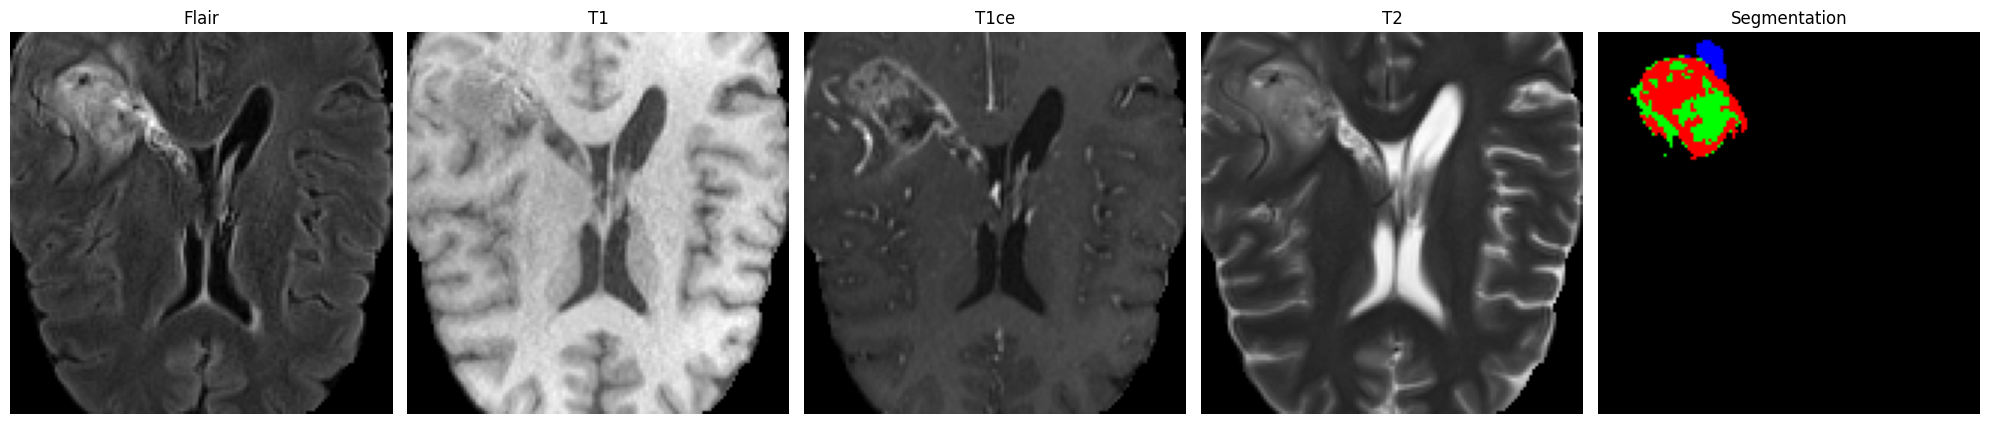

In [17]:
PATIENT_ID = 'BraTS20_Training_050'
DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
flair, t1, ce, t2, seg = load_and_preprocess(PATIENT_ID, DATASET_PATH)
visualize_modalities(flair, t1, ce, t2, seg,70)

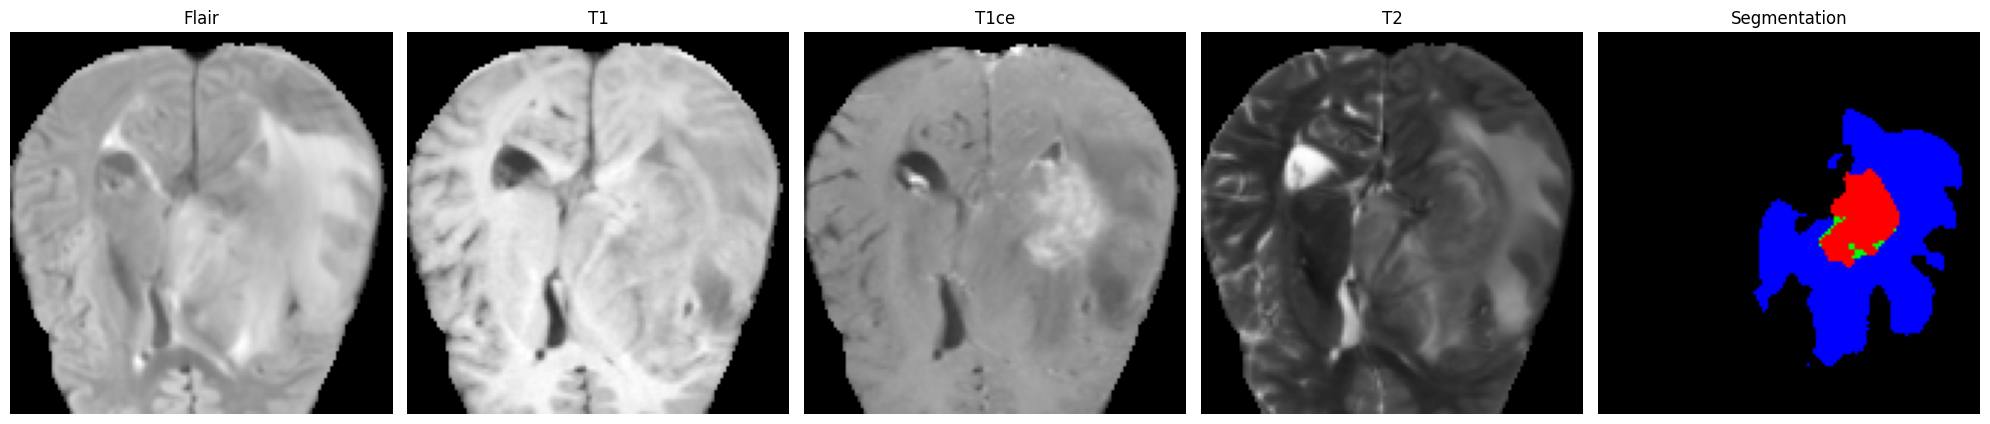

In [18]:
PATIENT_ID = 'BraTS20_Training_150'
DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
flair, t1, ce, t2, seg = load_and_preprocess(PATIENT_ID, DATASET_PATH)
visualize_modalities(flair, t1, ce, t2, seg,70)

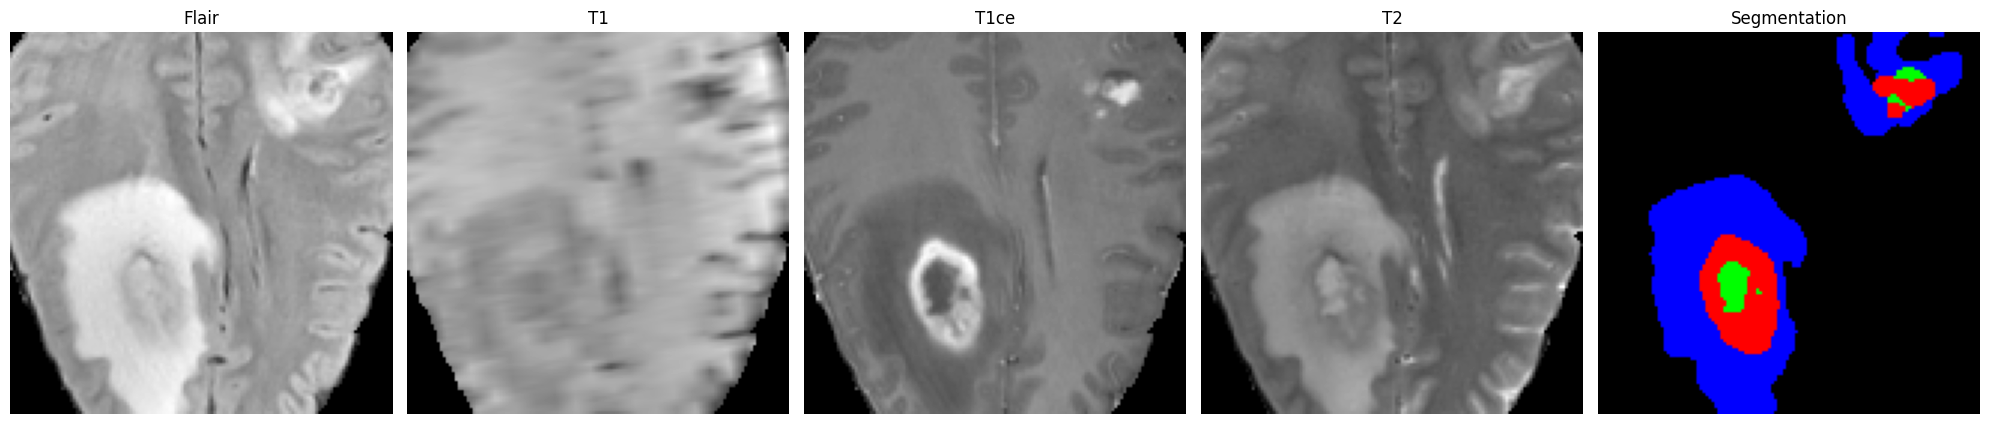

In [19]:
PATIENT_ID = 'BraTS20_Training_369'
DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData'
flair, t1, ce, t2, seg = load_and_preprocess(PATIENT_ID, DATASET_PATH)
visualize_modalities(flair, t1, ce, t2, seg,79)

In [20]:
IMG_SIZE=128

**Load Model and Predict**

In [21]:
# Test dataset patient IDs created by splitting training data
Test_IDs = ['BraTS20_Training_265', 'BraTS20_Training_196', 'BraTS20_Training_240', 'BraTS20_Training_328', 'BraTS20_Training_144', 'BraTS20_Training_234', 'BraTS20_Training_289', 'BraTS20_Training_235', 'BraTS20_Training_015', 'BraTS20_Training_140', 'BraTS20_Training_032', 'BraTS20_Training_153', 'BraTS20_Training_160', 
           'BraTS20_Training_011', 'BraTS20_Training_154', 'BraTS20_Training_226', 'BraTS20_Training_330', 'BraTS20_Training_280', 'BraTS20_Training_042', 'BraTS20_Training_088', 'BraTS20_Training_257', 'BraTS20_Training_037', 'BraTS20_Training_215', 'BraTS20_Training_272', 'BraTS20_Training_222', 'BraTS20_Training_156', 
           'BraTS20_Training_207', 'BraTS20_Training_038', 'BraTS20_Training_327', 'BraTS20_Training_074', 'BraTS20_Training_301', 'BraTS20_Training_252', 'BraTS20_Training_286', 'BraTS20_Training_064', 'BraTS20_Training_065', 'BraTS20_Training_248', 'BraTS20_Training_092', 'BraTS20_Training_090', 'BraTS20_Training_117', 
           'BraTS20_Training_350', 'BraTS20_Training_159', 'BraTS20_Training_029', 'BraTS20_Training_040']

In [23]:
model = tf.keras.models.load_model(
    '/kaggle/input/brats2020_5th_training/tensorflow2/default/1/BraTS_Trained_ResUNet_seg_Model1.h5',
    compile=False
)

In [24]:
import ipywidgets as widgets
from IPython.display import display

In [25]:
# Define function to view prediction for a patient using patient id
def view_Prediction_byID(case_ID):
    case_path = os.path.join(TRAIN_DATASET_PATH,case_ID)
    #patient_id_no = int(case_ID.split('_')[-1])
    
    #load flair, t2, t1ce and t1 data
    flair = nib.load(os.path.join(case_path,case_ID + '_flair.nii')).get_fdata()
    t2 = nib.load(os.path.join(case_path,case_ID + '_t2.nii')).get_fdata()
    t1ce = nib.load(os.path.join(case_path,case_ID + '_t1ce.nii')).get_fdata()
    t1 = nib.load(os.path.join(case_path,case_ID + '_t1.nii')).get_fdata()
    
    # Normalize volmes
    def normalize_volume(volume):
        mean = np.mean(volume)
        std = np.std(volume)
        return (volume - mean) / (std + 1e-8)
    flair = normalize_volume(flair)
    t2 = normalize_volume(t2)
    t1ce = normalize_volume(t1ce)
    t1 = normalize_volume(t1)

    stacked_volume = np.stack([flair,t2,t1ce,t1], axis = -1)
    stacked_volume_cropped = stacked_volume[56:184,56:184,13:141]

    #load ground truth seg
    seg_gt = nib.load(os.path.join(case_path,case_ID + '_seg.nii')).get_fdata()
    seg_gt = seg_gt[56:184,56:184,13:141]
    seg_gt = np.where(seg_gt == 4, 3, seg_gt)
    label = tf.one_hot(seg_gt.astype(np.uint8), depth=4).numpy()
    
    # predict
    prediction = model.predict(np.expand_dims(stacked_volume_cropped, axis=0))[0]   # 128 x 128 x 128 x 4

    # Visualization helpers
    modalities_dict = { 'Flair': 0, 'T2': 1, 'T1CE': 2, 'T1': 3 }
    view_options=['Axial', 'Coronal', 'Sagittal']

    def get_slices(view, volume, label, prediction, modality_index, slice_index):
        if view == "Axial":
            input_slice = volume[:, :, slice_index, modality_index]
            gt_slice = np.argmax(label[:, :, slice_index, :], axis=-1)
            pred_slice = np.argmax(prediction[:, :, slice_index, :], axis=-1)
        elif view == "Coronal":
            input_slice = volume[:, slice_index, :, modality_index]
            gt_slice = np.argmax(label[:, slice_index, :, :], axis=-1)
            pred_slice = np.argmax(prediction[:, slice_index, :, :], axis=-1)
        elif view == "Sagittal":
            input_slice = volume[slice_index, :, :, modality_index]
            gt_slice = np.argmax(label[slice_index, :, :, :], axis=-1)
            pred_slice = np.argmax(prediction[slice_index, :, :, :], axis=-1)
        return np.rot90(input_slice), np.rot90(gt_slice), np.rot90(pred_slice)
    def label_to_rgb(mask_slice):
        rgb = np.zeros((*mask_slice.shape, 3), dtype=np.float32)
        rgb[mask_slice == 1] = [0, 1, 0]   # ED - Green
        rgb[mask_slice == 2] = [0, 0, 1]   # ET - Blue
        rgb[mask_slice == 3] = [1, 0, 0]   # NC - Red
        return rgb

    def visualize_slice(slice_index, modality, view):
        modality_index = modalities_dict[modality]
        input_slice, gt_slice, pred_slice = get_slices(view, stacked_volume_cropped, label, prediction, modality_index, slice_index)
    
        gt_rgb = label_to_rgb(gt_slice)
        pred_rgb = label_to_rgb(pred_slice)
    
        fig, axes = plt.subplots(1, 3, figsize=(9, 3))
    
        axes[0].imshow(input_slice, cmap='gray')
        axes[0].set_title(f'{modality} | {view} View | Slice {slice_index}')
        axes[0].axis('off')
    
        axes[1].imshow(gt_rgb)
        axes[1].set_title('Ground Truth (RGB)')
        axes[1].axis('off')
    
        axes[2].imshow(pred_rgb)
        axes[2].set_title('Prediction (RGB)')
        axes[2].axis('off')
    
        plt.tight_layout()
        plt.show()


    # Widgets
    modality_dropdown = widgets.Dropdown(
        options=list(modalities_dict.keys()),
        value='Flair',
        description='Modality:'
    )
    
    view_dropdown = widgets.Dropdown(
        options=view_options,
        value='Axial',
        description='View:'
    )
    
    slice_slider = widgets.IntSlider(
        value=64,
        min=0,
        max=127,
        step=1,
        description='Slice:',
        continuous_update=False
    )
    
    ui = widgets.VBox([modality_dropdown, view_dropdown, slice_slider])
    out = widgets.interactive_output(
        visualize_slice,
        {'slice_index': slice_slider, 'modality': modality_dropdown, 'view': view_dropdown}
    )
    
    display(ui, out)

In [27]:
view_Prediction_byID(Test_IDs[41])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 757ms/step


Output()

In [28]:
view_Prediction_byID(Test_IDs[42])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 753ms/step


Output()

In [29]:
view_Prediction_byID(Test_IDs[8])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 785ms/step


Output()

In [30]:
view_Prediction_byID(Test_IDs[15])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step


Output()

In [31]:
view_Prediction_byID(Test_IDs[35])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step


Output()

In [32]:
view_Prediction_byID(Test_IDs[11])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 760ms/step


Output()

In [33]:
view_Prediction_byID(Test_IDs[13])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 741ms/step


Output()

In [34]:
view_Prediction_byID(Test_IDs[31])

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step


Output()

**Prepare confusion matrix for Test dataset**

In [36]:
from sklearn.metrics import confusion_matrix

In [40]:
import pandas as pd

In [41]:
# Confusion matrix setup
labels = [0, 1, 2, 3]  # Remapped from original BraTS: 0,1,2,4 → 0,1,2,3
conf_matrix = np.zeros((len(labels), len(labels)), dtype=np.int64)

# Normalize volmes
def normalize_volume(volume):
    mean = np.mean(volume)
    std = np.std(volume)
    return (volume - mean) / (std + 1e-8)
def load_modalities(patient_dir, pid):
    mods = ['flair', 't2', 't1ce', 't1']
    volumes = []
    for m in mods:
        img_path = os.path.join(patient_dir, f'{pid}_{m}.nii')
        img = nib.load(img_path).get_fdata()
        img = normalize_volume(img)
        volumes.append(img)
    stacked = np.stack(volumes, axis=-1)  # [H, W, D, 4]
    stacked_volume_cropped = stacked[56:184,56:184,13:141]
    return stacked_volume_cropped

for pid in Test_IDs:
    patient_dir = os.path.join(TRAIN_DATASET_PATH, pid)
    
    # Load image and label
    stacked_modalities = load_modalities(patient_dir, pid)  # [H, W, D, 4]
    label_path = os.path.join(patient_dir, f'{pid}_seg.nii')
    label = nib.load(label_path).get_fdata().astype(np.uint8)
    label = label[56:184,56:184,13:141]
    
    # Remap labels: 4 → 3
    label[label == 4] = 3

    # Predict
    prediction = model.predict(np.expand_dims(stacked_modalities, axis=0))[0] # [H, W, D, num_classes]
    pred_label = tf.argmax(prediction, axis=-1).numpy().astype(np.uint8)  # [H, W, D]

    # Flatten and accumulate confusion matrix
    y_true = label.flatten()
    y_pred = pred_label.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    conf_matrix += cm      


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 772ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 782ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 786ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 774ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 776ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 789ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 835ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 827ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 792ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 773ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [42]:
# Display Final Results
df = pd.DataFrame(conf_matrix, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
print("Confusion Matrix (Raw Counts):")
print(df)  

Confusion Matrix (Raw Counts):
          Pred_0  Pred_1   Pred_2  Pred_3
True_0  85309084   32769   243328   20509
True_1     53220  811384   241907   47275
True_2    287940  168051  2141618   31955
True_3     35773   39709    47099  665915


In [43]:
# Normalized row-wise
conf_matrix_normalized = conf_matrix.astype(np.float32) / conf_matrix.sum(axis=1, keepdims=True)
df_norm = pd.DataFrame(conf_matrix_normalized.round(3),
                       index=[f"True_{l}" for l in labels],
                       columns=[f"Pred_{l}" for l in labels])
print("\n Row-wise Normalized Confusion Matrix:")
print(df_norm)


 Row-wise Normalized Confusion Matrix:
        Pred_0  Pred_1  Pred_2  Pred_3
True_0   0.997   0.000   0.003   0.000
True_1   0.046   0.703   0.210   0.041
True_2   0.110   0.064   0.814   0.012
True_3   0.045   0.050   0.060   0.845


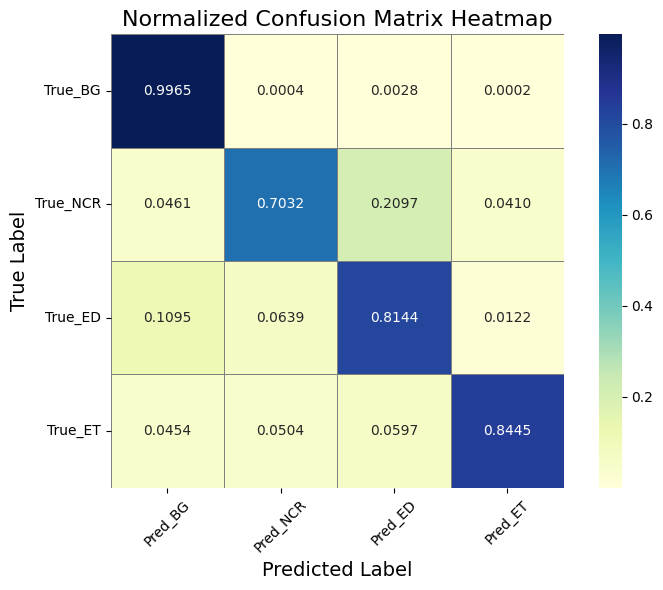

In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
labels = ["BG", "NCR", "ED", "ET"]
# Create a DataFrame for better axis labeling
df_cm = pd.DataFrame(conf_matrix_normalized,
                     index=[f"True_{l}" for l in labels],
                     columns=[f"Pred_{l}" for l in labels])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt=".4f", cmap='YlGnBu', cbar=True, square=True,
            linewidths=0.5, linecolor='gray')
plt.title("Normalized Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Prepare for Validation Dataset**

In [59]:
Validation_IDs =  ['BraTS20_Training_083', 'BraTS20_Training_127', 'BraTS20_Training_039', 'BraTS20_Training_031', 'BraTS20_Training_072', 'BraTS20_Training_110', 
                   'BraTS20_Training_077', 'BraTS20_Training_089', 'BraTS20_Training_175', 'BraTS20_Training_286', 'BraTS20_Training_140', 'BraTS20_Training_061', 
                   'BraTS20_Training_014', 'BraTS20_Training_302', 'BraTS20_Training_342', 'BraTS20_Training_158', 'BraTS20_Training_261', 'BraTS20_Training_099', 
                   'BraTS20_Training_118', 'BraTS20_Training_250', 'BraTS20_Training_367', 'BraTS20_Training_314', 'BraTS20_Training_173', 'BraTS20_Training_309', 
                   'BraTS20_Training_106', 'BraTS20_Training_209', 'BraTS20_Training_041', 'BraTS20_Training_013', 'BraTS20_Training_362', 'BraTS20_Training_278', 
                   'BraTS20_Training_135', 'BraTS20_Training_008', 'BraTS20_Training_113', 'BraTS20_Training_195', 'BraTS20_Training_101', 'BraTS20_Training_018', 
                   'BraTS20_Training_277', 'BraTS20_Training_257', 'BraTS20_Training_194', 'BraTS20_Training_052', 'BraTS20_Training_352', 'BraTS20_Training_076', 
                   'BraTS20_Training_129', 'BraTS20_Training_262', 'BraTS20_Training_232', 'BraTS20_Training_043', 'BraTS20_Training_154', 'BraTS20_Training_296', 
                   'BraTS20_Training_017', 'BraTS20_Training_207', 'BraTS20_Training_211', 'BraTS20_Training_038', 'BraTS20_Training_189', 'BraTS20_Training_159', 
                   'BraTS20_Training_156', 'BraTS20_Training_062', 'BraTS20_Training_063', 'BraTS20_Training_081', 'BraTS20_Training_292', 'BraTS20_Training_066', 
                   'BraTS20_Training_272', 'BraTS20_Training_080', 'BraTS20_Training_338']

In [60]:
# Confusion matrix setup
labels = [0, 1, 2, 3]  # Remapped from original BraTS: 0,1,2,4 → 0,1,2,3
conf_matrix = np.zeros((len(labels), len(labels)), dtype=np.int64)

for pid in Validation_IDs:
    patient_dir = os.path.join(TRAIN_DATASET_PATH, pid)
    
    # Load image and label
    stacked_modalities = load_modalities(patient_dir, pid)  # [H, W, D, 4]
    label_path = os.path.join(patient_dir, f'{pid}_seg.nii')
    label = nib.load(label_path).get_fdata().astype(np.uint8)
    label = label[56:184,56:184,13:141]
    
    # Remap labels: 4 → 3
    label[label == 4] = 3

    # Predict
    prediction = model.predict(np.expand_dims(stacked_modalities, axis=0))[0] # [H, W, D, num_classes]
    pred_label = tf.argmax(prediction, axis=-1).numpy().astype(np.uint8)  # [H, W, D]

    # Flatten and accumulate confusion matrix
    y_true = label.flatten()
    y_pred = pred_label.flatten()
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    conf_matrix += cm 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 852ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 831ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 842ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 780ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 828ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 766ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 806ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 829ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 813ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 796ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 809ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 818ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [61]:
# Display Final Results
df = pd.DataFrame(conf_matrix, index=[f"True_{l}" for l in labels], columns=[f"Pred_{l}" for l in labels])
print("Confusion Matrix (Raw Counts):")
print(df) 

# Normalized row-wise
conf_matrix_normalized = conf_matrix.astype(np.float32) / conf_matrix.sum(axis=1, keepdims=True)
df_norm = pd.DataFrame(conf_matrix_normalized.round(3),
                       index=[f"True_{l}" for l in labels],
                       columns=[f"Pred_{l}" for l in labels])
print("\n Row-wise Normalized Confusion Matrix:")
print(df_norm)

Confusion Matrix (Raw Counts):
           Pred_0  Pred_1   Pred_2  Pred_3
True_0  126505460   14375   382979   20783
True_1      62319  832258   152067   59259
True_2     282890  146936  2671858   57486
True_3      42126   42929    47208  799643

 Row-wise Normalized Confusion Matrix:
        Pred_0  Pred_1  Pred_2  Pred_3
True_0   0.997   0.000   0.003   0.000
True_1   0.056   0.753   0.138   0.054
True_2   0.090   0.047   0.846   0.018
True_3   0.045   0.046   0.051   0.858


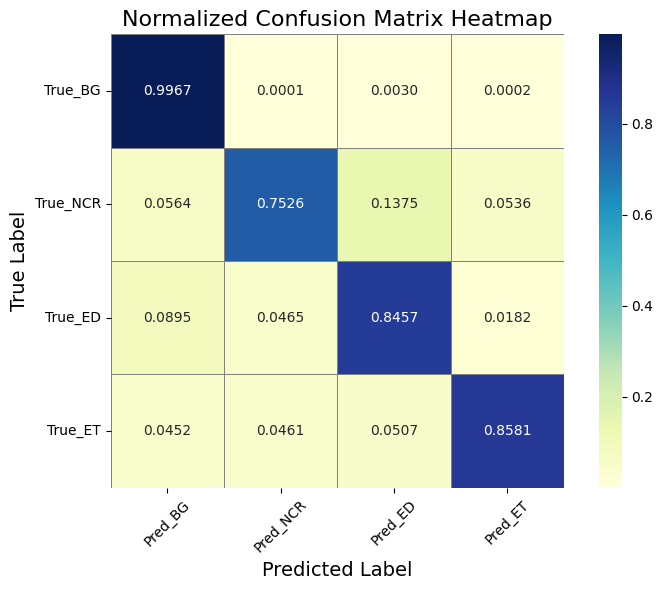

In [62]:
labels = ["BG", "NCR", "ED", "ET"]
# Create a DataFrame for better axis labeling
df_cm = pd.DataFrame(conf_matrix_normalized,
                     index=[f"True_{l}" for l in labels],
                     columns=[f"Pred_{l}" for l in labels])

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df_cm, annot=True, fmt=".4f", cmap='YlGnBu', cbar=True, square=True,
            linewidths=0.5, linecolor='gray')
plt.title("Normalized Confusion Matrix Heatmap", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Visualize Training and Validation curves using Training.log file**

In [63]:
import pandas as pd

In [64]:
history = pd.read_csv('/kaggle/input/our-training-log/training.log',sep=',',engine = 'python')
hist = history
hist

epoch  accuracy  dice_coef   dice_et   dice_tc   dice_wt    iou_et  \
0       0  0.971971   0.581815  0.522887  0.533203  0.738892  0.411686   
1       1  0.979214   0.664206  0.634538  0.659271  0.830143  0.519783   
2       2  0.979689   0.680423  0.640030  0.682973  0.833274  0.527220   
3       3  0.981323   0.690971  0.656408  0.698964  0.846963  0.542333   
4       4  0.982591   0.707543  0.672884  0.720442  0.855923  0.561759   
5       5  0.982218   0.707987  0.670300  0.721634  0.850821  0.559495   
6       6  0.983456   0.725695  0.683413  0.735748  0.865133  0.575015   
7       7  0.984176   0.736633  0.697072  0.759102  0.872392  0.587022   
8       8  0.984167   0.737459  0.694091  0.756849  0.864675  0.584758   
9       9  0.984519   0.744448  0.698361  0.770303  0.872622  0.590877   
10     10  0.984695   0.752292  0.709247  0.781229  0.871957  0.602882   
11     11  0.984644   0.749022  0.703503  0.773610  0.868583  0.596447   
12     12  0.986143   0.767338  0.719296  0.797027  0.881376  0.615215   
13     13  0.986687   0.773793  0.724283  0.807197  0.889896  0.621721   
14     14  0.986984   0.775796  0.727892  0.810818  0.892124  0.625717   
15     15  0.987160   0.777565  0.727140  0.814368  0.895818  0.624340   
16     16  0.987387   0.780806  0.732065  0.818825  0.896191  0.629760   
17     17  0.987427   0.781765  0.728244  0.817364  0.897333  0.627685   
18     18  0.987397   0.781923  0.733329  0.818553  0.896769  0.632352   
19     19  0.987478   0.785986  0.738253  0.823609  0.898349  0.637050   
20     20  0.987642   0.785904  0.736429  0.824492  0.899818  0.634842   
21     21  0.987817   0.787745  0.738991  0.829612  0.900768  0.638310   
22     22  0.987963   0.791593  0.745339  0.832110  0.901675  0.644414   
23     23  0.987951   0.791348  0.742757  0.831643  0.903094  0.642360   
24     24  0.987933   0.790087  0.740279  0.829506  0.901655  0.640362   
25     25  0.987979   0.791760  0.744657  0.836122  0.901461  0.643609   
26     26  0.988233   0.792864  0.743765  0.835696  0.905498  0.644432   
27     27  0.988171   0.797019  0.752056  0.836040  0.903529  0.651698   
28     28  0.988179   0.796929  0.749161  0.840229  0.905656  0.649335   
29     29  0.988428   0.797349  0.749232  0.842939  0.905015  0.649709   
30     30  0.988681   0.803273  0.754051  0.848218  0.908769  0.655774   
31     31  0.988775   0.804593  0.754425  0.850509  0.909608  0.657044   
32     32  0.988765   0.803649  0.754346  0.850667  0.909285  0.656301   
33     33  0.988861   0.806397  0.755839  0.853200  0.910369  0.658427   
34     34  0.988893   0.806761  0.756298  0.854630  0.910568  0.658499   
35     35  0.988926   0.806802  0.757131  0.852847  0.910619  0.658957   
36     36  0.988908   0.807458  0.758294  0.854491  0.910701  0.660331   
37     37  0.988996   0.807692  0.759432  0.857814  0.910694  0.661881   
38     38  0.988962   0.806901  0.756345  0.856010  0.911228  0.658714   
39     39  0.988997   0.809220  0.759882  0.858962  0.911035  0.661849   

      iou_tc    iou_wt  learning_rate  ...  val_iou_tc  val_iou_wt  val_loss  \
0   0.410841  0.630462   1.000000e-04  ...    0.519804    0.752421  0.714216   
1   0.536185  0.731247   1.000000e-04  ...    0.566579    0.762091  0.501470   
2   0.561917  0.736702   1.000000e-04  ...    0.576152    0.768234  0.406011   
3   0.577200  0.751808   1.000000e-04  ...    0.606334    0.781838  0.345047   
4   0.601770  0.763680   1.000000e-04  ...    0.583059    0.773660  0.319673   
5   0.606930  0.758348   1.000000e-04  ...    0.612415    0.774549  0.300142   
6   0.625887  0.777099   1.000000e-04  ...    0.626790    0.780219  0.280999   
7   0.647336  0.787057   1.000000e-04  ...    0.671218    0.788861  0.260003   
8   0.649448  0.778683   1.000000e-04  ...    0.676218    0.788662  0.253663   
9   0.664162  0.787663   1.000000e-04  ...    0.677852    0.785742  0.243434   
10  0.679022  0.786318   1.000000e-04  ...    0.639586    0.790581  0.251001   
11  0.669

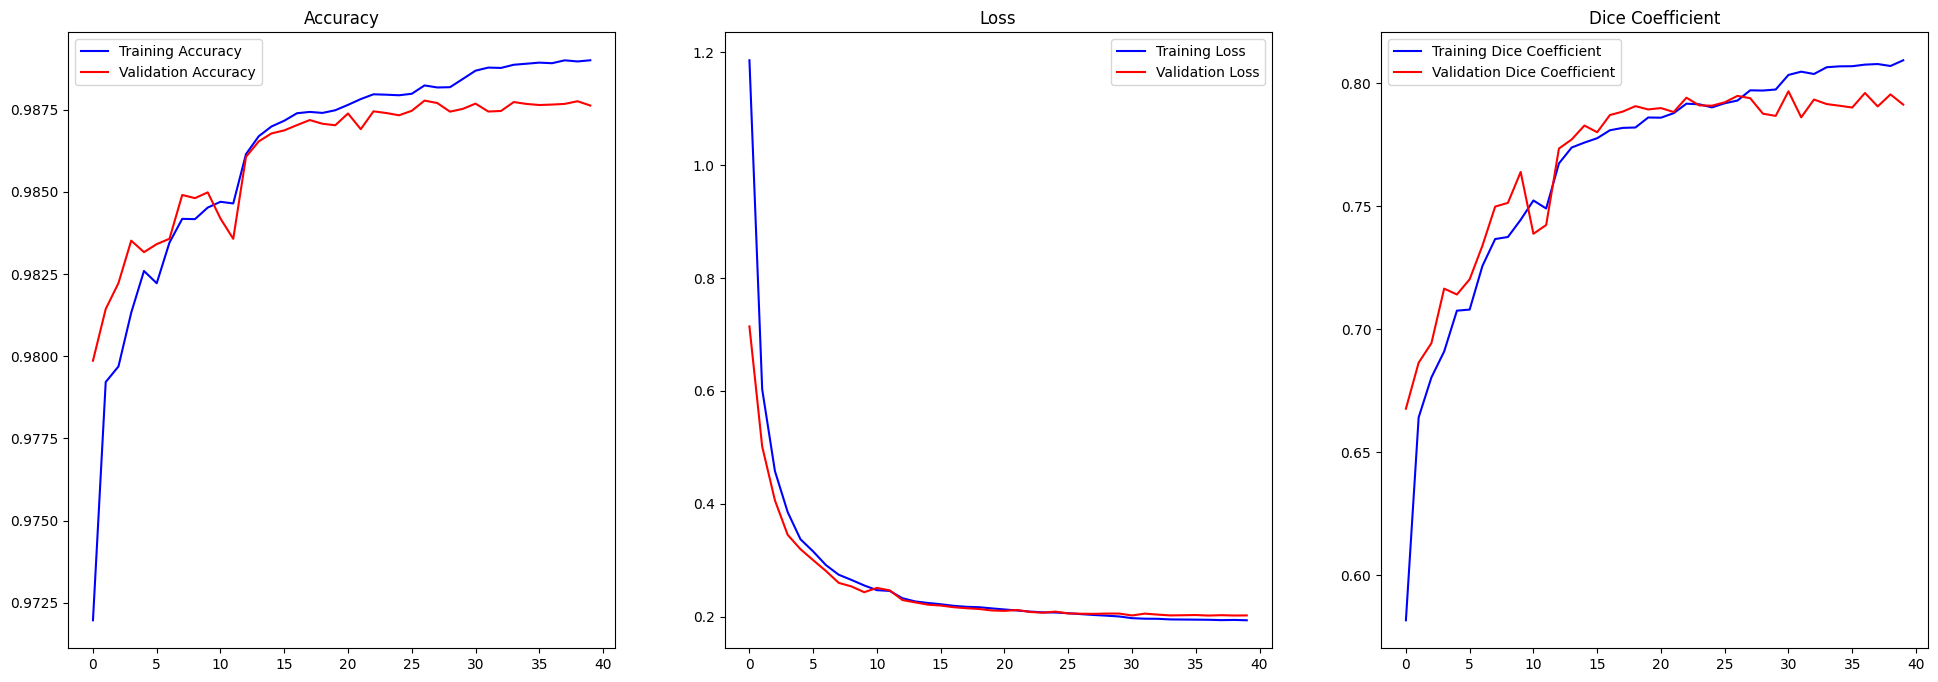

In [65]:
# Extract metrics
acc = hist['accuracy']
val_acc = hist['val_accuracy']
epoch = range(len(acc))
loss = hist['loss']
val_loss = hist['val_loss']


# Plotting
f, ax = plt.subplots(1, 3, figsize=(24, 8))

# Training and Validation Accuracy
ax[0].plot(epoch, acc, 'b', label='Training Accuracy')
ax[0].plot(epoch, val_acc, 'r', label='Validation Accuracy')
ax[0].legend()
ax[0].set_title('Accuracy')

# Training and Validation Loss
ax[1].plot(epoch, loss, 'b', label='Training Loss')
ax[1].plot(epoch, val_loss, 'r', label='Validation Loss')
ax[1].legend()
ax[1].set_title('Loss')

train_dice = hist['dice_coef']  # Replace with actual column name for training Dice coefficient
val_dice = hist['val_dice_coef']

# Training and Validation Dice Coefficient
ax[2].plot(epoch, train_dice, 'b', label='Training Dice Coefficient')
ax[2].plot(epoch, val_dice, 'r', label='Validation Dice Coefficient')
ax[2].legend()
ax[2].set_title('Dice Coefficient')

plt.show()

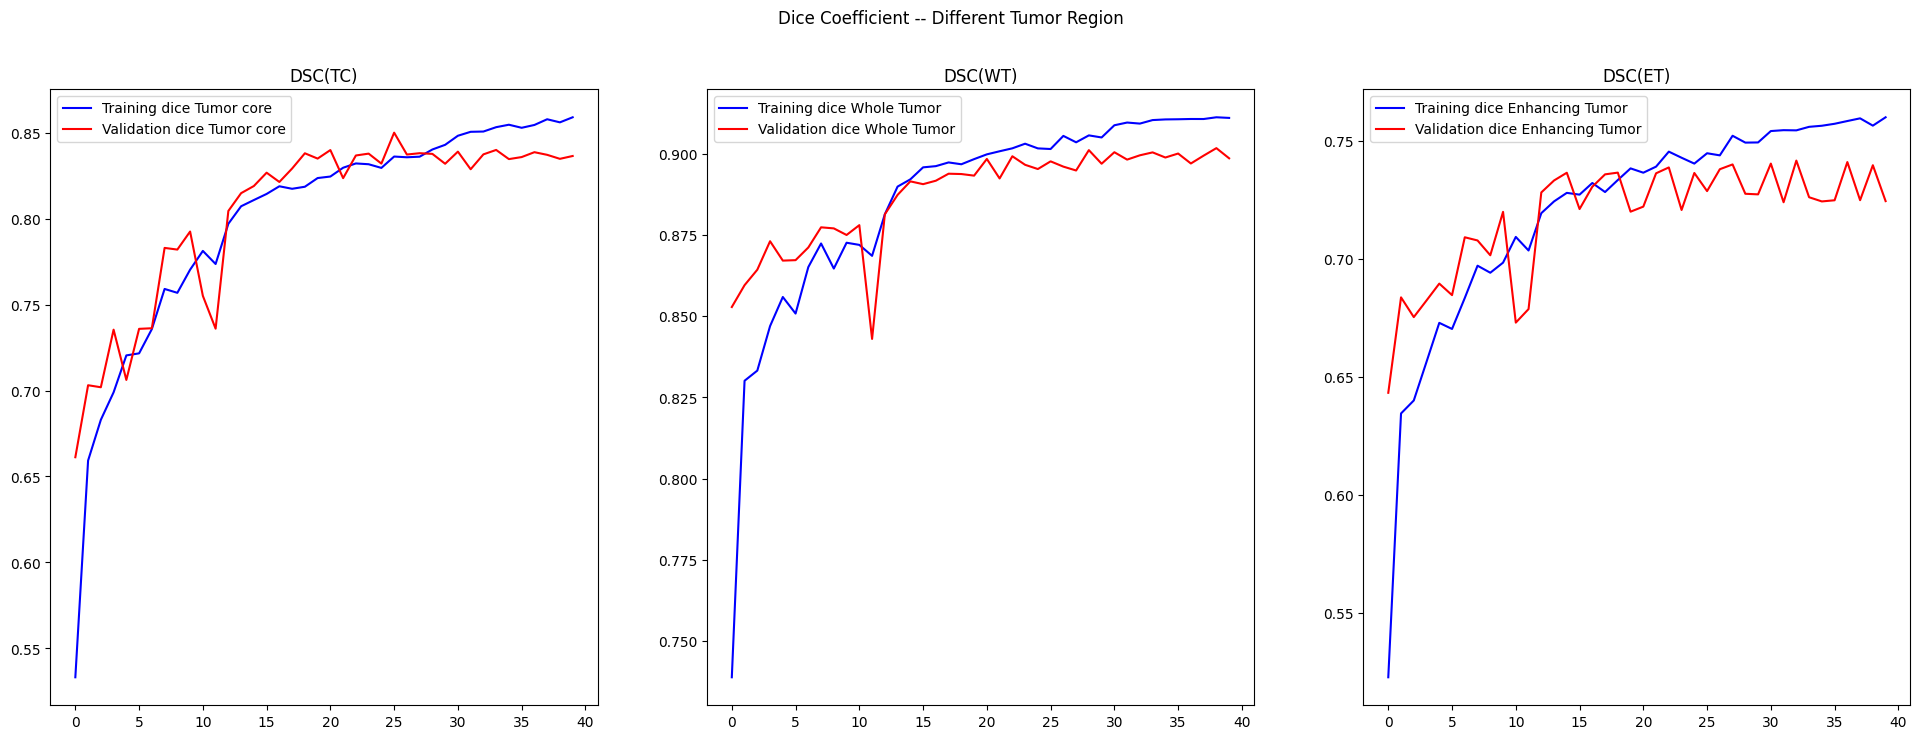

In [66]:
f, ax = plt.subplots(1, 3, figsize=(24, 8))

train_dice_tc = hist['dice_tc']
val_dice_tc = hist['val_dice_tc']

ax[0].plot(epoch, train_dice_tc, 'b', label='Training dice Tumor core')
ax[0].plot(epoch, val_dice_tc, 'r', label='Validation dice Tumor core')
ax[0].legend()
ax[0].set_title('DSC(TC)')

train_dice_wt = hist['dice_wt']
val_dice_wt = hist['val_dice_wt']

ax[1].plot(epoch, train_dice_wt, 'b', label='Training dice Whole Tumor')
ax[1].plot(epoch, val_dice_wt, 'r', label='Validation dice Whole Tumor')
ax[1].legend()
ax[1].set_title('DSC(WT)')

train_dice_et = hist['dice_et'] 
val_dice_et = hist['val_dice_et']


ax[2].plot(epoch, train_dice_et, 'b', label='Training dice Enhancing Tumor')
ax[2].plot(epoch, val_dice_et, 'r', label='Validation dice Enhancing Tumor')
ax[2].legend()
ax[2].set_title('DSC(ET)')
plt.suptitle('Dice Coefficient -- Different Tumor Region')

plt.show()

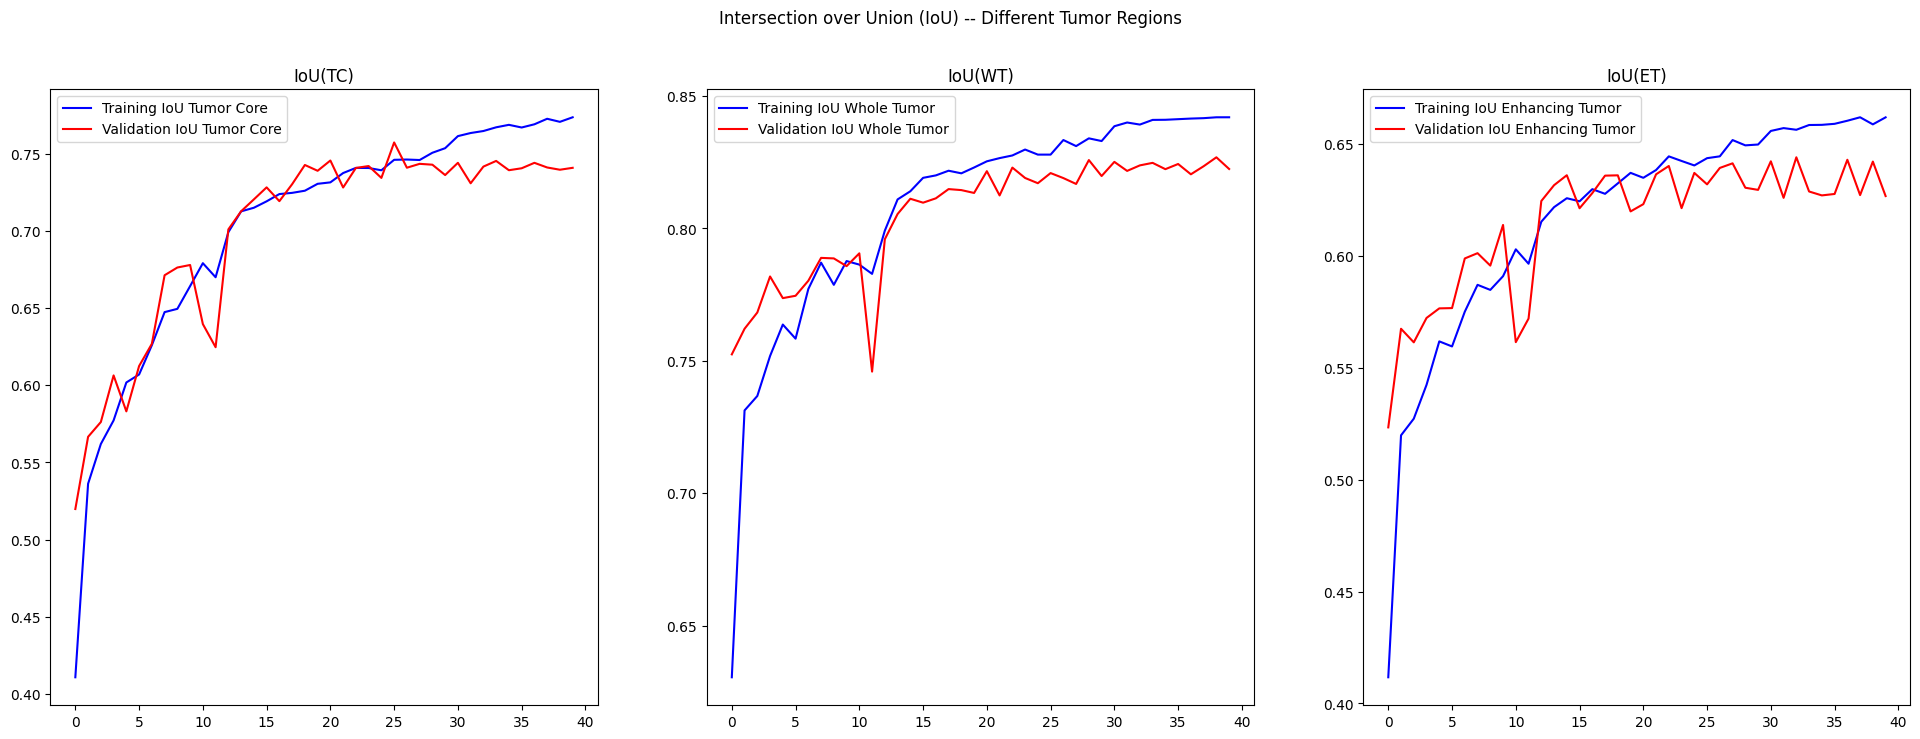

In [67]:
import matplotlib.pyplot as plt

# Create subplots
f, ax = plt.subplots(1, 3, figsize=(24, 8))

epoch = range(len(hist['iou_tc']))

# IOU - Tumor Core
train_iou_tc = hist['iou_tc']
val_iou_tc = hist['val_iou_tc']
ax[0].plot(epoch, train_iou_tc, 'b', label='Training IoU Tumor Core')
ax[0].plot(epoch, val_iou_tc, 'r', label='Validation IoU Tumor Core')
ax[0].legend()
ax[0].set_title('IoU(TC)')

# IOU - Whole Tumor
train_iou_wt = hist['iou_wt']
val_iou_wt = hist['val_iou_wt']
ax[1].plot(epoch, train_iou_wt, 'b', label='Training IoU Whole Tumor')
ax[1].plot(epoch, val_iou_wt, 'r', label='Validation IoU Whole Tumor')
ax[1].legend()
ax[1].set_title('IoU(WT)')

# IOU - Enhancing Tumor
train_iou_et = hist['iou_et'] 
val_iou_et = hist['val_iou_et']
ax[2].plot(epoch, train_iou_et, 'b', label='Training IoU Enhancing Tumor')
ax[2].plot(epoch, val_iou_et, 'r', label='Validation IoU Enhancing Tumor')
ax[2].legend()
ax[2].set_title('IoU(ET)')

# Super title
plt.suptitle('Intersection over Union (IoU) -- Different Tumor Regions')
plt.show()

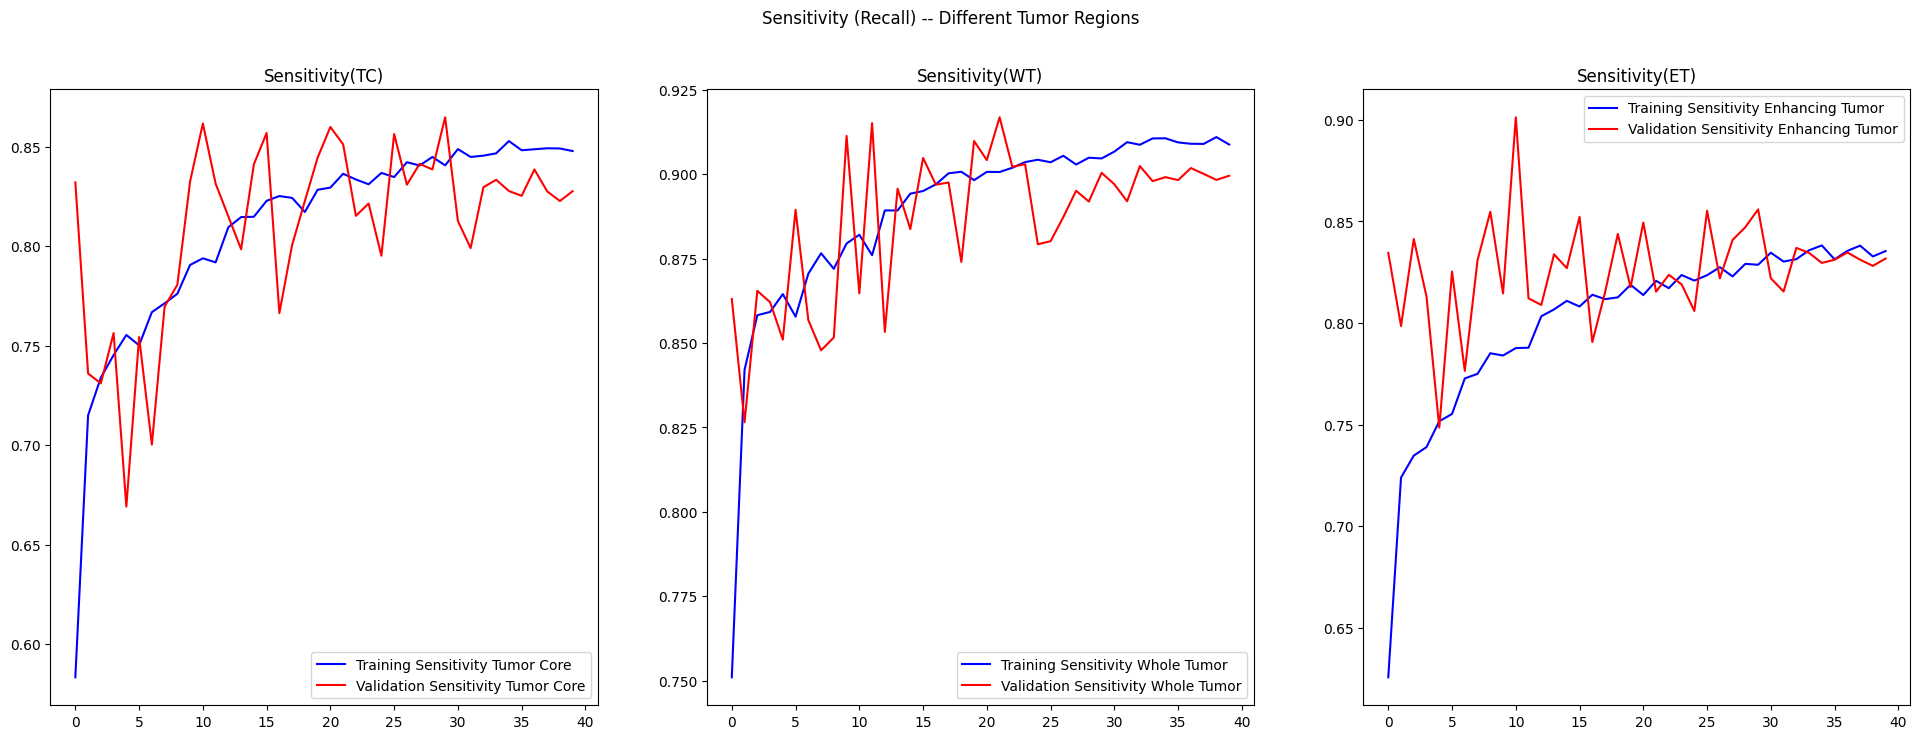

In [68]:
import matplotlib.pyplot as plt

epoch = range(len(hist['sensitivity_tc']))

# Create subplots
f, ax = plt.subplots(1, 3, figsize=(24, 8))

# Sensitivity - Tumor Core
train_sens_tc = hist['sensitivity_tc']
val_sens_tc = hist['val_sensitivity_tc']
ax[0].plot(epoch, train_sens_tc, 'b', label='Training Sensitivity Tumor Core')
ax[0].plot(epoch, val_sens_tc, 'r', label='Validation Sensitivity Tumor Core')
ax[0].legend()
ax[0].set_title('Sensitivity(TC)')

# Sensitivity - Whole Tumor
train_sens_wt = hist['sensitivity_wt']
val_sens_wt = hist['val_sensitivity_wt']
ax[1].plot(epoch, train_sens_wt, 'b', label='Training Sensitivity Whole Tumor')
ax[1].plot(epoch, val_sens_wt, 'r', label='Validation Sensitivity Whole Tumor')
ax[1].legend()
ax[1].set_title('Sensitivity(WT)')

# Sensitivity - Enhancing Tumor
train_sens_et = hist['sensitivity_et'] 
val_sens_et = hist['val_sensitivity_et']
ax[2].plot(epoch, train_sens_et, 'b', label='Training Sensitivity Enhancing Tumor')
ax[2].plot(epoch, val_sens_et, 'r', label='Validation Sensitivity Enhancing Tumor')
ax[2].legend()
ax[2].set_title('Sensitivity(ET)')

# Set the main title
plt.suptitle('Sensitivity (Recall) -- Different Tumor Regions')

# Show the plot
plt.show()


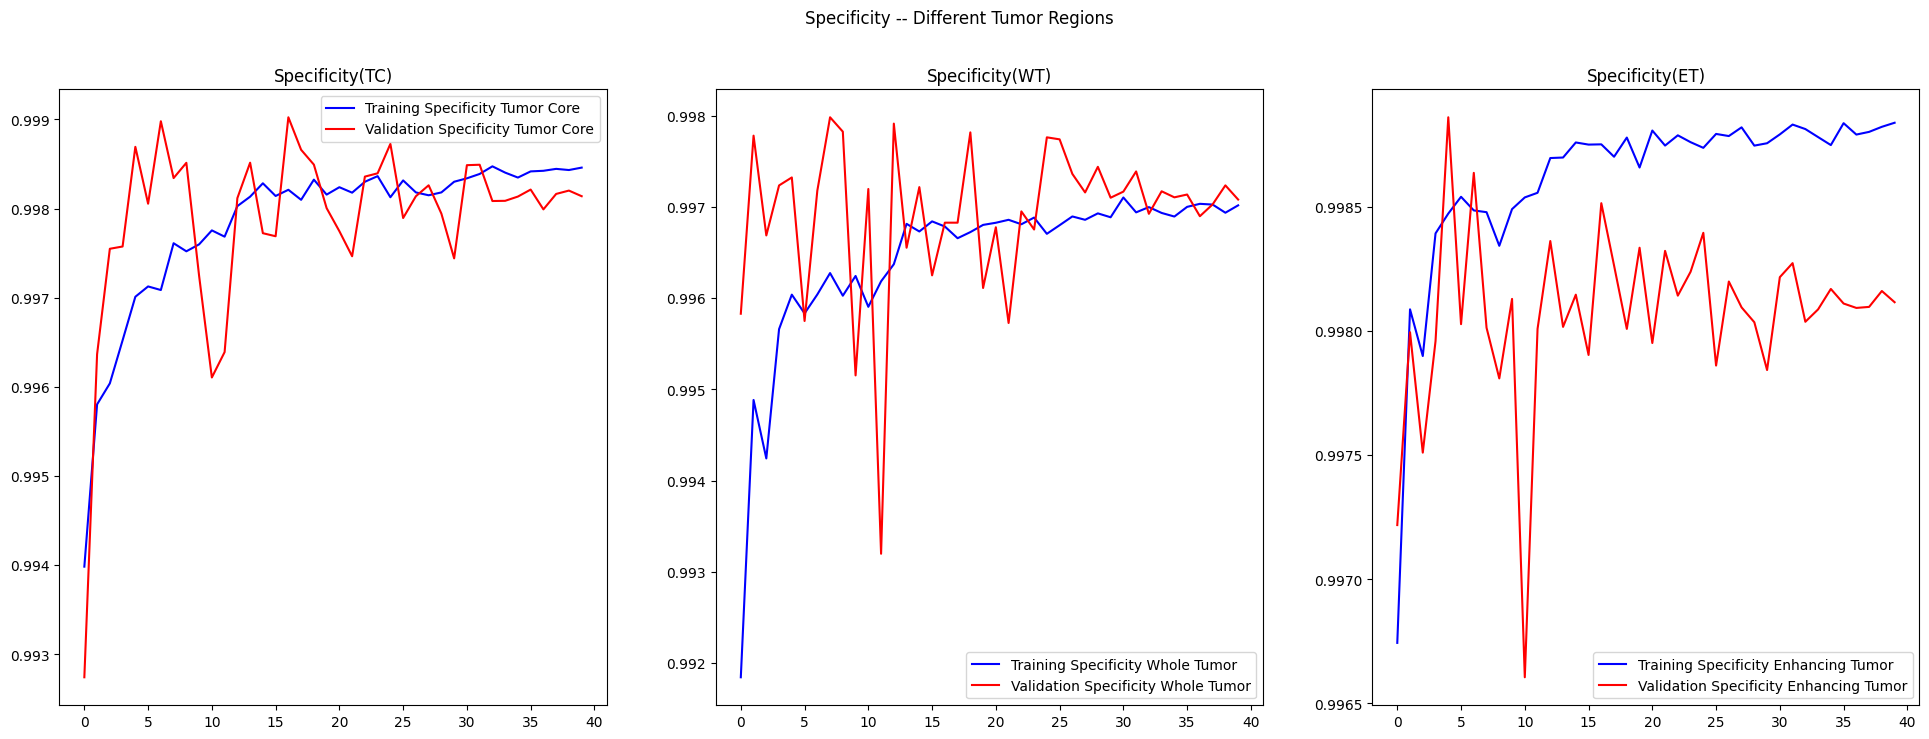

In [69]:
import matplotlib.pyplot as plt


epoch = range(len(hist['specificity_tc']))

# Create subplots
f, ax = plt.subplots(1, 3, figsize=(24, 8))

# Specificity - Tumor Core
train_spec_tc = hist['specificity_tc']
val_spec_tc = hist['val_specificity_tc']
ax[0].plot(epoch, train_spec_tc, 'b', label='Training Specificity Tumor Core')
ax[0].plot(epoch, val_spec_tc, 'r', label='Validation Specificity Tumor Core')
ax[0].legend()
ax[0].set_title('Specificity(TC)')

# Specificity - Whole Tumor
train_spec_wt = hist['specificity_wt']
val_spec_wt = hist['val_specificity_wt']
ax[1].plot(epoch, train_spec_wt, 'b', label='Training Specificity Whole Tumor')
ax[1].plot(epoch, val_spec_wt, 'r', label='Validation Specificity Whole Tumor')
ax[1].legend()
ax[1].set_title('Specificity(WT)')

# Specificity - Enhancing Tumor
train_spec_et = hist['specificity_et']
val_spec_et = hist['val_specificity_et']
ax[2].plot(epoch, train_spec_et, 'b', label='Training Specificity Enhancing Tumor')
ax[2].plot(epoch, val_spec_et, 'r', label='Validation Specificity Enhancing Tumor')
ax[2].legend()
ax[2].set_title('Specificity(ET)')

# Super title
plt.suptitle('Specificity -- Different Tumor Regions')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Learning Rate through Epochs')

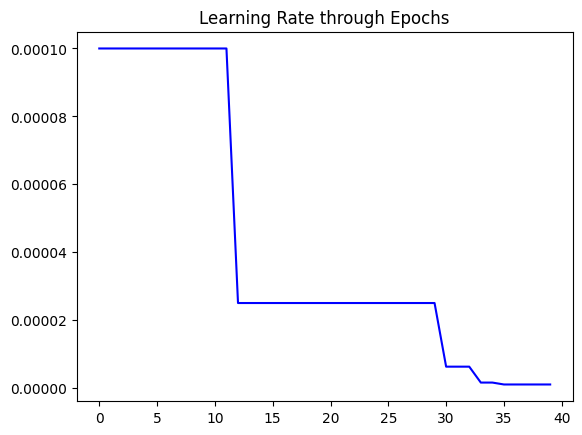

In [70]:
plt.plot(epoch,hist['learning_rate'],'b')
plt.title("Learning Rate through Epochs")